# A first analysis of the COMPAS dataset

## Dataset description

We will examine the ProPublica COMPAS dataset, which contains the records of all criminal defendants who were subject to COMPAS screening in Broward County, Florida, during 2013 and 2014. For each defendant, various information fields (‘features’) were gathered by ProPublica. Broadly, these fields are related to the defendant’s demographic information (e.g., gender and race), criminal history (e.g., the number of prior offenses) and administrative information about the case (e.g., the case number, arrest date). Finally, the dataset contains the risk of recidivism predicted by the COMPAS tool, and also information about whether the defendant did actually recidivate or not (ground truth label for us).

The COMPAS score uses answers to 137 questions to assign a risk score to defendants -- essentially an estimate of the likelihood of re-arrest. The actual output is two-fold: a risk rating of 1-10 and a "low", "medium", or "high" risk label.

Link to dataset: https://github.com/propublica/compas-analysis

The file we will analyze is: compas-scores-two-years.csv

Link to the ProPublica article:

https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Some of the code below is adapted from the Propublica github repository above, and from

https://investigate.ai/propublica-criminal-sentencing/week-5-1-machine-bias-class/

## Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [18]:
info = {
    "Email": "abdoul.zeba@polytechnique.edu",
    "Alias": "Tokic",  # (change this in case you want to identify yourself on the leaderboard)
}

## Download the data

We first need to load the data from the ProPublica repo:
https://github.com/propublica/compas-analysis

In [19]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction
from sklearn import preprocessing

In [20]:
%matplotlib inline

import urllib.request
import os,sys

from random import seed, shuffle

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file '%s' in the current directory..." % fname)

    if fname not in files:
        print("'%s' not found! Downloading from GitHub..." % fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("'%s' download and saved locally..",fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory..


## Loading and cleaning data

The following code load the data using pandas and cleans it according to ProPublica's cleaning: 

"
If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.

We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.

In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed

We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility." 
"

Finally, it converts the data to a dictionary with np arrays, which will be useful later

In [21]:
# load the file
df = pd.read_csv(COMPAS_INPUT_FILE)
# print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

df = df[
    (df.days_b_screening_arrest <= 30) &  
    (df.days_b_screening_arrest >= -30) &  
    (df.is_recid != -1) &
    (df.c_charge_degree != 'O') &
    (df.score_text != 'N/A')
]

df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again
# df.shape

# Conversion to dictionary with np arrays
data = df.to_dict('list')
for k in data.keys():
    data[k] = np.array(data[k])

## Exploring the dataset

The following pandas commands are very convenient to explore the data. Uncomment them to explore the data. 

<span style="color:red">TODO</span>: Add a command to print the number of defendents per race. 

In the following, we will look mostly at African-Americans and Caucasians(termed blacks and whites for short)

In [22]:
# df.head() # check some examples of data
# df.columns # prints the features
# df.isnull().sum() #check for missing values
# df.describe() # generates descriptive statistics (e.g., to check for outliers)
# df.race.unique() # different races we have in the dataset
# df.age_cat.value_counts() #number of people by age category
# df.score_text.value_counts() #number of people by COMPAS risk category

# TODO: Insert your code below this
df.groupby('race').size()

race
African-American    3175
Asian                 31
Caucasian           2103
Hispanic             509
Native American       11
Other                343
dtype: int64

## Basic analysis of the bias in COMPAS scores

We now look at the COMPAS scores (deciles first, then text scores) as a function of the sensitive attribute (race or gender) to observe potential differences. 

We start by observing the scores for different groupes. 

<span style="color:red">TODO</span>: Plot the histograms of decile scores for Black and White defendant and observe the difference. 

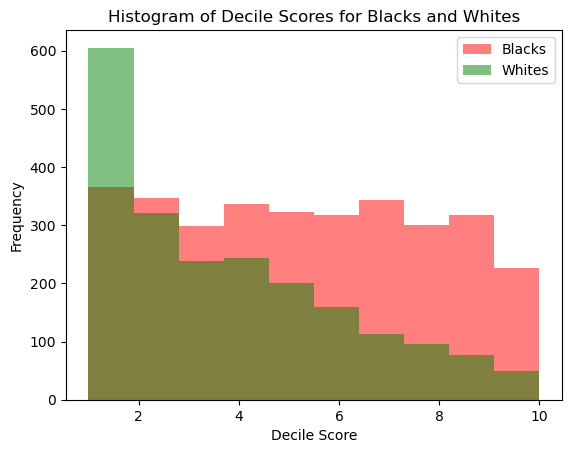

In [23]:
# Histogram of decile scores for Blacks (blue) and Whites (orange)
# TODO: Insert your code below this
import matplotlib.pyplot as plt

blacks = df[df['race'] == 'African-American']
whites = df[df['race'] == 'Caucasian']

plt.hist(blacks['decile_score'], bins=10, color='red', alpha=0.5, label='Blacks')
plt.hist(whites['decile_score'], bins=10, color='green', alpha=0.5, label='Whites')

plt.xlabel('Decile Score')
plt.ylabel('Frequency')
plt.title('Histogram of Decile Scores for Blacks and Whites')

plt.legend()
plt.show()


The above observation can be explained by a dependence between the race and true label.

In [24]:
# recidivism rates by race
recid_race = pd.crosstab(df.race, df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
recid_race

two_year_recid,0,1,rate
race,,,
African-American,1514,1661,0.523150
Asian,23,8,0.258065
Caucasian,1281,822,0.390870
Hispanic,320,189,0.371316
Native American,6,5,0.454545
Other,219,124,0.361516


We now look at whether we observe a similar phenomenon on the text scores of COMPAS (low, medium, high risk).

In [25]:
# high risk rates by race
score_race = pd.crosstab(df.race, df.score_text)
score_race['High risk rate'] = score_race['High'] / score_race.sum(axis=1)
score_race

score_text,High,Low,Medium,High risk rate
race,,,,
African-American,845,1346,984,0.266142
Asian,3,24,4,0.096774
Caucasian,223,1407,473,0.106039
Hispanic,47,368,94,0.092338
Native American,4,3,4,0.363636
Other,22,273,48,0.064140


### Fairness metrics for the COMPAS scores

We do not have the actual scores that are used to compte text scores Low-Med-High; hence we cannot investigate directly the calibration. However, we can use the decile score as a proxy, and we can investigate PPV. 

Let us first plot the probability of recidivism by decile score. We observe that it is not very far from a diagonale.

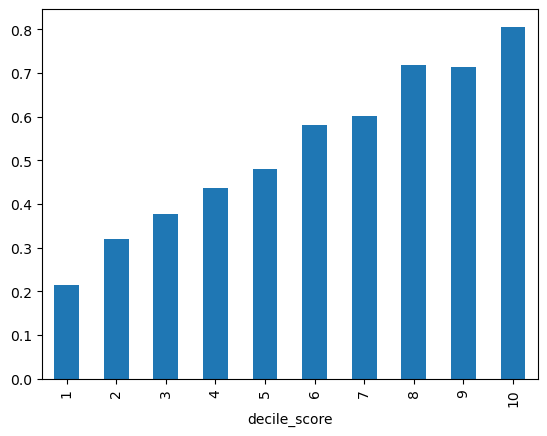

In [26]:
# probability of recidivism by decile
df.groupby(df.decile_score)['two_year_recid'].mean().plot(kind='bar')


<span style="color:red">TODO</span>: Plot a similar graph with separated bars for Blacks and Whites. 

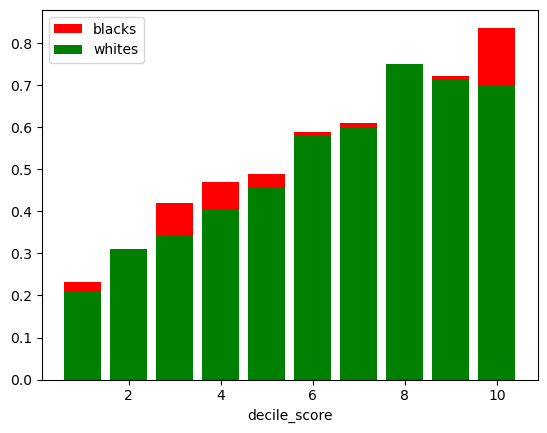

In [27]:
plt.bar(x=blacks.groupby(df.decile_score)['two_year_recid'].mean().index, height=blacks.groupby(df.decile_score)['two_year_recid'].mean(), color='red', label='blacks')
plt.bar(x=whites.groupby(df.decile_score)['two_year_recid'].mean().index, height=whites.groupby(df.decile_score)['two_year_recid'].mean(), color='green', label='whites')
plt.xlabel('decile_score')

plt.legend()
plt.show()

To further analyze the COMPAS score as a classifier, we transform it into a binary outcome by splitting "low" (class 0) from "medium or high" risk (class 1). We can then compute standard quantities such as the confusion matrix or PPV.

In [28]:
# COMPAS recidivism confusion matrix
df['guessed_recid'] = df.score_text != 'Low'
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid)
cm # for "confusion matrix"

guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


We finally compute the PPV, TPR and FPR of the COMPAS classifier. 

<span style="color:red">TODO</span>: Complete the print_ppv_fpv function. Observe the differences in the metrics between Blacks and Whites and comment. 

In [29]:
# cm is a confusion matrix. The rows are guessed, the columns are actual 
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    # Fix: Complete the formula by providing the denominator for the accuracy calculation and closing the parentheses
    print('Accuracy: ', (TN + TP) / (TN + TP + FN + FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()


def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)   
    
print('White')
subset = df[df.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = df[df.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)

White
actual   False  True 
guessed              
False      999    408
True       282    414

Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black
actual   False  True 
guessed              
False      873    473
True       641   1188

Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298



Conclusion: the False Positive Rate is substantially higher for black defendants, but the PPV is similar between blacks and whites. That is, the COMPAS score satisfies sufficiency, but not separation. 

## Training a classifier from the ground truth label

We now train a classifier (a simple logistic regression) on the label two_year_recid. We work on a subset of features: ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]. 

<span style="color:red">TODO</span>: Complete the model definition and fitting. 

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict

FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] #features to be used for classification
CONT_VARIABLES = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the decision variable
SENSITIVE_ATTRS = ["race"]


y = data[CLASS_FEATURE]
X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
x_control = defaultdict(list)

for attr in FEATURES_CLASSIFICATION:
    vals = data[attr]
    if attr in CONT_VARIABLES:
        vals = [float(v) for v in vals]
        vals = preprocessing.scale(vals) # 0 mean and 1 variance  
        vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

    else: # this encodes categorical variables in a numerical way -- there are other ways to do it
        enc = preprocessing.LabelBinarizer()
        enc.fit(vals)
        vals = enc.transform(vals)

    # add to learnable features
    X = np.hstack((X, vals))

    
# the following is a very dirty way to keep track of the race after the train_test_split    
ind = data["race"]=="African-American"
X_b = X[ind] 
y_b = y[ind]
ind = data["race"]=="Caucasian"
X_w = X[ind]        
y_w = y[ind]
ind = [data["race"][i]!="Caucasian" and data["race"][i]!="African-American" for i in range(len(y))]
X_n = X[ind]        
y_n = y[ind]
    
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.3, random_state=1234)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_w, y_w, test_size=0.3, random_state=5678)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=9012)

X_train = np.vstack((X_train_b, X_train_w, X_train_n))
y_train = np.hstack((y_train_b, y_train_w, y_train_n))
X_test = np.vstack((X_test_b, X_test_w, X_test_n))
y_test = np.hstack((y_test_b, y_test_w, y_test_n))


In [31]:
# TODO: Uncomment and complete the code below
model = LogisticRegression(solver='liblinear', random_state=45)
model.fit(X_train, y_train)

LogisticRegression(random_state=45, solver='liblinear')

We can then compute the model accuracy. Compare to the COMPAS accuracy. 

In [32]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6540744738262277


We can also plot the ROC curve for the model on the global population. 

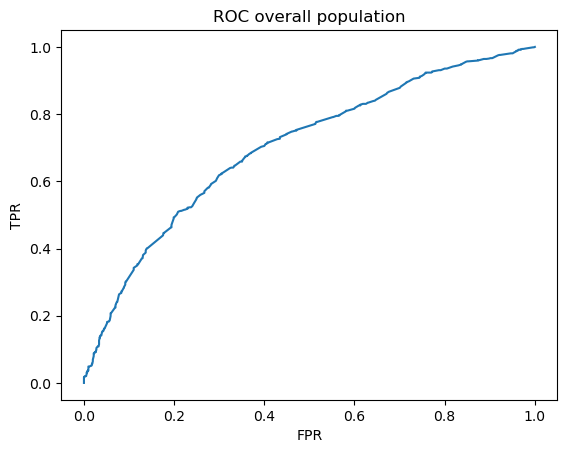

In [33]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])

plt.plot(fpr, tpr)

plt.title('ROC overall population')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


<span style="color:red">TODO</span>: Plot the ROC curve for Blacks and Whites in two separate curves (in the same plot). What do you observe?

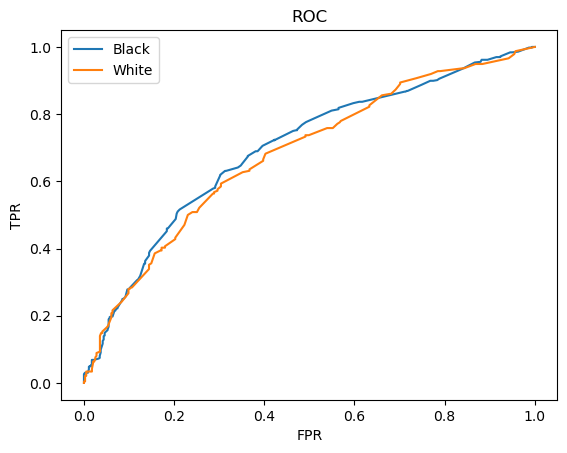

In [44]:
from sklearn.metrics import roc_curve
# TODO: Insert your code below this line
scores_black = model.predict_proba(X_test_b)
fpr_black, tpr_black, thresholds_black = roc_curve(y_test_b, scores_black[:,1])

scores_white = model.predict_proba(X_test_w)
fpr_white, tpr_white, thresholds_white = roc_curve(y_test_w, scores_white[:,1])

plt.plot(fpr_black, tpr_black, label='Black')
plt.plot(fpr_white, tpr_white, label='White')

plt.title('ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

We can finally check the fairness of this simple logistic regression, when choosing an arbitrary threshold common to the two groups. 

<span style="color:red">TODO</span>: Compute the predictions for a common threshold (threshold_common), then compute the PPV, TPR, FPR (you can use the print_metrics function from above). Comment. 

In [54]:
threshold_common = 0.5
# TODO: Insert your code below this line
y_pred_black = scores_black[:,1] > threshold_common
y_pred_white = scores_white[:,1] > threshold_common

def print_dif_metrics(cm):
    TN = cm[0][0]   
    TP = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    print('Accuracy: ', (TN + TP) / (TN + TP + FN + FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(y_test, y_pred):
    cm = pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['guessed'])
    print(cm)
    print()
    print_dif_metrics(cm)

print('Black')
print_metrics(y_test_b, y_pred_black)
print('White')
print_metrics(y_test_w, y_pred_white)


Black
guessed  False  True 
actual               
0          298    159
1          175    321

Accuracy:  0.6495278069254984
PPV:  0.6471774193548387
FPR:  0.3699788583509514
FNR:  0.33125

White
guessed  False  True 
actual               
0          324     71
1          141     95

Accuracy:  0.6640253565768621
PPV:  0.4025423728813559
FPR:  0.3032258064516129
FNR:  0.42771084337349397



Finally, we can also investigate the calibration more finely using the calibration module from sklearn. 

<span style="color:red">TODO</span>: Complete the code below to plot the calibration curve for the whole population.

In [56]:
from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# TODO: Uncomment and complete the code below
scores = model.predict_proba(X_test)
prob_true, prob_pred = calibration_curve(y_test, scores[:,1], n_bins=10)

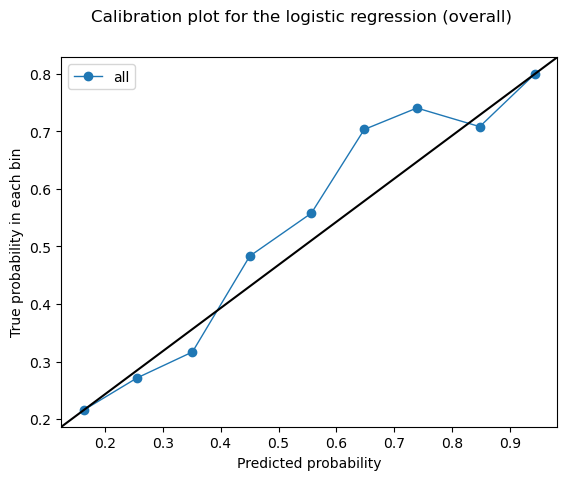

In [57]:


fig, ax = plt.subplots()
# only this line is calibration curves
plt.plot(prob_pred,prob_true, marker='o', linewidth=1, label='all')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for the logistic regression (overall)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

<span style="color:red">TODO</span>: Complete the code below to plot the calibration curve for the blacks and white separately. Conclude. 

In [58]:
# TODO: Uncomment and complete the code below
scores_black = model.predict_proba(X_test_b)
prob_true_b, prob_pred_b = calibration_curve(y_test_b, scores_black[:,1], n_bins=10)
scores_white = model.predict_proba(X_test_w)
prob_true_w, prob_pred_w = calibration_curve(y_test_w, scores_white[:,1], n_bins=10)


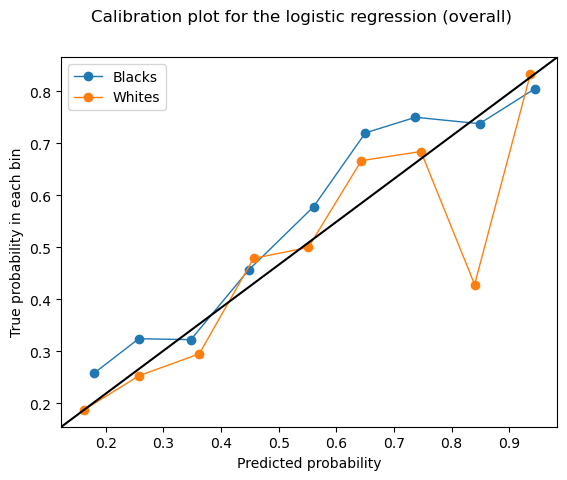

In [59]:
fig, ax = plt.subplots()
# only this line is calibration curves
plt.plot(prob_pred_b,prob_true_b, marker='o', linewidth=1, label='Blacks')
plt.plot(prob_pred_w,prob_true_w, marker='o', linewidth=1, label='Whites')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for the logistic regression (overall)')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

## A Quick Quiz

There is a pdf sheet associated with the lab with some quiz questions, as covered in the lecture. Replace the '[]' in the `answers` dictionary, such that `answers[q]` is **is a subset of** `['a', 'b', 'c', 'd', 'e']`, providing the answers to question number `q`, (of questions 1,2,3).

In [ ]:
answers = {
    1 : ['c', 'd'],
    2 : ['a', 'b'], 
    3 : ['b'], 
}
# 